In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split


In [47]:
df = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/project final/old_dataset1.csv") ## Load the dataset

In [3]:
df.head()

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,Transaction_Day,Transaction_Weekday,Time_Category
0,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,32415.45,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,Bitcoin transaction,23,3,Afternoon
1,Female,51,Maharashtra,Nashik,Nashik Branch,Business,43622.60,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,Grocery delivery,11,5,Evening
2,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,63062.56,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,Mutual fund investment,25,5,Night
3,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,14000.72,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,Food delivery,19,6,Afternoon
4,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,18335.16,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,Debt repayment,30,3,Evening


## Load train and test sets

In [ ]:
train = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/project final/old_processed_train_set.csv") ## Load the processed train set
test = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/project final/old_processed_test_set.csv")  ## Load the processed test set

In [5]:
train.columns

Index(['Age', 'State', 'Transaction_Amount', 'Transaction_Type',
       'Merchant_Category', 'Account_Balance', 'Transaction_Device',
       'Is_Fraud', 'Transaction_Day', 'Transaction_Weekday', 'Gender_Male',
       'Account_Type_Checking', 'Account_Type_Savings', 'Device_Type_Desktop',
       'Device_Type_Mobile', 'Device_Type_POS', 'Time_Category_Evening',
       'Time_Category_Morning', 'Time_Category_Night', 'City_target_enc',
       'Bank_Branch_target_enc', 'Transaction_Location_target_enc',
       'Transaction_Description_target_enc'],
      dtype='object')

In [ ]:
## We will get the features and target variables separeted for both train and test sets
X_train = train.drop(columns='Is_Fraud')   
y_train = train['Is_Fraud']
X_test = test.drop(columns='Is_Fraud')
y_test = test['Is_Fraud']

## Apply SMOTETomek

In [ ]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42) 
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


In [8]:
df_resampled = pd.DataFrame(X_resampled, columns=train.columns) ## features train
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())

Is_Fraud
0    139223
1     63258
Name: count, dtype: int64


## Models and Performance Metrics

In [9]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import matplotlib.pyplot as plt

In [ ]:
## Following is a function which will be reused several times. This function includes the possible models and the evaluation metrics

def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df



## Train and evaluate the model


🔹 Training Logistic Regression...



c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 202481, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

🔹 Training KNeighbors...


🔹 Training Random Forest...


🔹 Training Stacking Ensemble...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

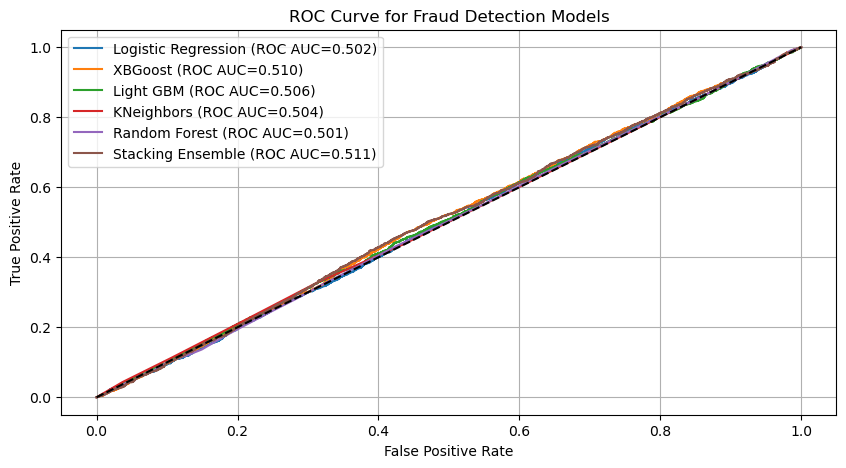

In [11]:
evaluation = modelling(X_resampled, y_resampled, X_test, y_test)

In [12]:
evaluation

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,0.5022,0.9018,0.0504,0.0530,0.0517
1,XBGoost,0.5104,0.9480,0.0294,0.0010,0.0019
2,Light GBM,0.5061,0.9495,0.0000,0.0000,0.0000
3,KNeighbors,0.5041,0.7718,0.0527,0.2076,0.0841
4,Random Forest,0.5009,0.9436,0.0458,0.0059,0.0105
5,Stacking Ensemble,0.5105,0.9468,0.0333,0.0020,0.0037


**Summary:**  
*In the previous step, I applied SMOTETomek to the training set to address the issue of imbalanced classes. However, despite this preprocessing, the final train-test split remained imbalanced. I then selected several machine learning models, including Logistic Regression and KNN, along with ensemble algorithms such as Random Forest, LightGBM, and XGBoost. Additionally, I implemented ensemble learning using Stacking to train and evaluate the models.*  

*The evaluation metrics used are the ROC-AUC score, accuracy score, and classification report. However, given the rarity of fraud cases in the dataset, accuracy is not an ideal metric as it can be misleading. The ROC-AUC score is a more suitable metric for binary classification. Upon analyzing the scores across all models, it is evident that they are all close to 0.50, with Stacking and XGBoost slightly higher at around 0.51. This suggests that these models perform no better than random guessing. Similarly, the recall values are too low to be considered reliable indicators. The ROC-AUC curve further confirms this pattern, highlighting the models' poor performance in distinguishing fraudulent cases.*

In [51]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_resampled,y_resampled)
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Convert to a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": feature_importances
})

# Sort by importance (highest to lowest)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


In [14]:
feature_importance_df

,Feature,Importance
1,State,0.057596
2,Transaction_Amount,0.055088
17,Time_Category_Night,0.054687
5,Account_Balance,0.054538
16,Time_Category_Morning,0.053459
10,Account_Type_Checking,0.047989
21,Transaction_Description_target_enc,0.047784
3,Transaction_Type,0.046036
0,Age,0.045724
7,Transaction_Day,0.044518


In [15]:
## Select features with greater than 0.04 importance
threshold = 0.04
selected_features = feature_importance_df[feature_importance_df["Importance"] > threshold]["Feature"].tolist()

In [16]:
## Refine x_resample and x_test
X_resampled_selected = X_resampled[selected_features]
X_test_selected = X_test[selected_features]


🔹 Training Logistic Regression...



c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 202481, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Training KNeighbors...


🔹 Training Random Forest...


🔹 Training Stacking Ensemble...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 202481, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 50606, number of negative: 111378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] N

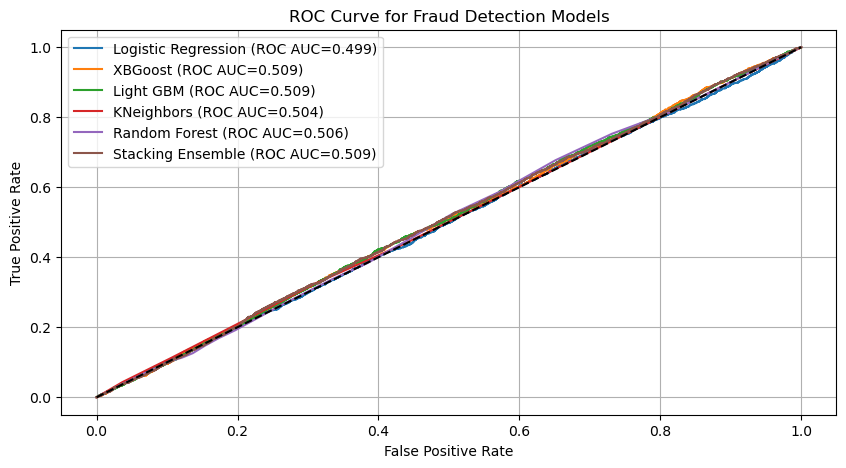

In [ ]:
## Use selected features to train the model again
results_selected = modelling(X_resampled_selected,y_resampled, X_test_selected, y_test)

In [18]:
results_selected

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,0.4992,0.8834,0.0512,0.0748,0.0608
1,XBGoost,0.5087,0.9495,0.0000,0.0000,0.0000
2,Light GBM,0.5090,0.9496,0.0000,0.0000,0.0000
3,KNeighbors,0.5041,0.7718,0.0527,0.2076,0.0841
4,Random Forest,0.5062,0.9472,0.0208,0.0010,0.0019
5,Stacking Ensemble,0.5093,0.9495,0.0000,0.0000,0.0000


**Summary:**  
*One potential way to enhance model performance is through feature selection using Random Forest. By leveraging the feature importance scores from a Random Forest model, we can identify the  relevant variables that contribute to fraud detection. Eliminating less important or redundant features may help reduce noise and improve model generalization. Additionally, focusing on key features could enhance interpretability and allow models to better distinguish between fraudulent and non-fraudulent transactions.*

*The evaluation results persist to indicate that all models perform poorly in detecting fraud cases. All ROC-AUC scores decline and are close to 0.50, suggesting that the models are no better than random guessing. While accuracy appears high, it is misleading due to the extreme class imbalance. The recall scores for fraud detection are particularly low, with some models, such as XGBoost, LightGBM, and the Stacking Ensemble, failing to detect any fraud cases at all. The ROC curve further confirms this, as the models' performance follows a near-random classification pattern. These results highlight the challenges of fraud detection.*


## Feature Engineering

In [46]:
data = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/Bank_Transaction_Fraud_Detection.csv")

In [20]:
df_copy = train
df_copy2 = test

**Ratio-Based Behaviorial Feature Engineering:**  
* This indicator shows how a transaction compares to a user's historical spending behavior because fraudsters often make transactions much larger than the customer’s usual spending pattern.*

In [ ]:
## Apply to both  sets using the same algorithm
df_copy["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")
df_copy2["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")

**Behavioral Feature Engineering (transactions_per_day) and Aggregated Statistical Features (unique_merchants):**  
* transactions_per_day can help us identify fraudulent bulk transactions in the dataset.
* unique_merhants can be a signal to fraudster testing a stolen card at multiple stores.

In [ ]:
df_copy["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")
df_copy2["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy2["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")

**Behavioral Feature Engineering (average_spending_per_day) and Anomaly Detection Features (spending_change):**  
* average_spending_per_day helps us to observe the daily spending and fradsters tend to make large amount of spendings or withdraws.
* spending_change is used to compare an individual transaction amount to the user's daily average spending. Thus, high values mean the transaction is much larger than usual, which could indicate fraud

In [ ]:
df_copy["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]
df_copy2["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy2["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]

In [24]:
df_copy2.head()

,Age,State,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Is_Fraud,Transaction_Day,Transaction_Weekday,...,Time_Category_Night,City_target_enc,Bank_Branch_target_enc,Transaction_Location_target_enc,Transaction_Description_target_enc,amount_to_avg_ratio,transactions_per_day,unique_merchants,average_spending_per_day,spending_change
0,49,0.029031,95015.64,2,0,8579.75,5,0,7,1,...,True,0.042530,0.042530,0.042530,0.047725,1.0,1,1,32415.45,1.422045
1,21,0.029600,59784.62,2,0,65738.54,17,0,16,3,...,False,0.036105,0.036105,0.036105,0.055188,1.0,1,1,43622.60,0.163414
2,26,0.029806,82561.18,4,1,9857.93,1,0,23,3,...,False,0.037152,0.037152,0.037152,0.054466,1.0,1,1,63062.56,0.040088
3,25,0.029700,91900.63,2,4,58082.67,12,0,12,6,...,True,0.050861,0.050861,0.050861,0.057359,1.0,1,1,14000.72,2.748866
4,43,0.029425,36058.15,1,2,33791.81,9,0,11,5,...,True,0.058453,0.058453,0.058453,0.047967,1.0,1,1,18335.16,4.844718


## Train and evaluate the models again

In [25]:
X_train = df_copy.drop(columns='Is_Fraud')
y_train = df_copy['Is_Fraud']
X_test = df_copy2.drop(columns='Is_Fraud')
y_test = df_copy2['Is_Fraud']

In [26]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
df_resampled = pd.DataFrame(X_resampled, columns=df_copy.columns) ## features df_copy
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())

Is_Fraud
0    145933
1     69968
Name: count, dtype: int64


In [27]:
def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df




🔹 Training Logistic Regression...



c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi


🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Info] Number of positive: 69968, number of negative: 145933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 215901, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Training KNeighbors...


🔹 Training Random Forest...


🔹 Training Stacking Ensemble...

[LightGBM] [Info] Number of positive: 69968, number of negative: 145933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 215901, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 55974, number of negative: 116746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] N

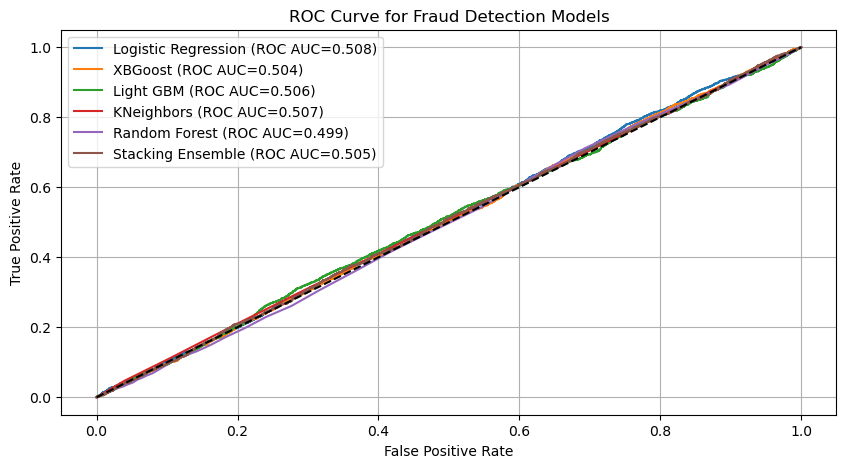

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,0.5083,0.9496,0.0000,0.0000,0.0000
1,XBGoost,0.5038,0.9486,0.0000,0.0000,0.0000
2,Light GBM,0.5062,0.9496,0.0000,0.0000,0.0000
3,KNeighbors,0.5067,0.7806,0.0530,0.1987,0.0837
4,Random Forest,0.4988,0.9454,0.0444,0.0040,0.0073
5,Stacking Ensemble,0.5046,0.9479,0.0149,0.0005,0.0010


In [28]:
modelling(X_resampled, y_resampled, X_test, y_test)

**Summary:**  
*The previous results emphasize the challenges of fraud detection and highlight the need for improved techniques, such as feature engineering.*  

*The current evaluation results are consistent with the previous findings, showing no significant improvement in model performance. All models continue to struggle with fraud detection, as evidenced by ROC-AUC scores close to 0.50, indicating performance similar to random guessing. While most models achieve high accuracy, this metric is misleading due to the extreme class imbalance. The recall scores for fraud detection remain particularly low, with Logistic Regression, XGBoost, LightGBM, and Stacking Ensemble failing to identify any fraudulent cases (recall = 0.000). K-Nearest Neighbors demonstrates the highest recall (0.1987), but its overall effectiveness remains poor. The ROC curve further confirms these findings, illustrating the models' lack of discriminatory power.*  

In [29]:
from sklearn.metrics import precision_recall_curve

## We will switch the X_resample and y_resample  to the original ones using the train and test sets
model = xgb.XGBClassifier(random_state =42)
model.fit(X_resampled, y_resampled)
y_probs = model.predict_proba(X_test)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
optimal_threshold = thresholds[recall.argmax()]  # Choose threshold maximizing recall

y_pred_adjusted = (y_probs > optimal_threshold).astype(int)


In [30]:
roc_auc = roc_auc_score(y_test, y_probs)

# Print Performance Metrics
print(f"🔹 ROC-AUC Score: {roc_auc:.4f}")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("🔹 Confusion Matrix:\n", conf_matrix)


🔹 ROC-AUC Score: 0.5038
🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     37982
           1       0.05      1.00      0.10      2018

    accuracy                           0.05     40000
   macro avg       0.53      0.50      0.05     40000
weighted avg       0.95      0.05      0.00     40000

🔹 Confusion Matrix:
 [[    1 37981]
 [    0  2018]]


*Thus, from the previous evaluations, overall speaking, the XGBoost model has a better performance and so we will use it and save it.*

## Save the model and the notebook to github.

In [32]:
xgb_model = xgb.XGBClassifier(random_state =42)


In [33]:
import pickle
with open("old_xgb_fraud_model.pkl","wb") as f:
    pickle.dump(xgb_model, f)


In [55]:
import pickle
with open("lightgbm_fraud_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

## Autoencoder

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [39]:
# Define features and target
X = df.drop(columns=["Is_Fraud"])  # Features
y = df["Is_Fraud"]  # Target variable

In [40]:
## Find the categorical columns
categorical_cols = ['Gender', 'Account_Type', 'Device_Type', 'Time_Category', 'Transaction_Type',
                    'Merchant_Category', 'Transaction_Device', 'State', 'City', 'Bank_Branch',
                    'Transaction_Location', 'Transaction_Description']

## Combine different encoding strategies
one_hot_cols = ['Gender', 'Account_Type', 'Transaction_Type']  
label_cols = ['Time_Category']  
freq_cols = ['Device_Type', 'Transaction_Device', 'State', 'City', 'Bank_Branch'] 
target_cols = ['Merchant_Category', 'Transaction_Location', 'Transaction_Description']  

## Apply encoding
X = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)

le = LabelEncoder()
for col in label_cols:
    X[col] = le.fit_transform(X[col])

freq_map = {col: X[col].value_counts().to_dict() for col in freq_cols}
for col in freq_cols:
    X[col] = X[col].map(freq_map[col])

te = TargetEncoder()
X[target_cols] = te.fit_transform(X[target_cols], y)

In [41]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train-test (Train on Normal Transactions Only)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Select only Non-Fraud transactions for Autoencoder Training
X_train_normal = X_train[y_train == 0]  

In [42]:
input_dim = X_train_normal.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)
encoded = Dense(4, activation="relu")(encoded)

decoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded) 

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse") 

In [43]:
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.9097 - val_loss: 0.7842
Epoch 2/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7789 - val_loss: 0.7673
Epoch 3/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7673 - val_loss: 0.7612
Epoch 4/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7639 - val_loss: 0.7548
Epoch 5/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7570 - val_loss: 0.7532
Epoch 6/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7563 - val_loss: 0.7525
Epoch 7/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7547 - val_loss: 0.7514
Epoch 8/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7544 - val_loss: 0.7515
Epoch 9/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7544 - val_loss: 0.7510
Epoch 10/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7542 - val_loss: 0.7507
Epoch 11/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7534 - val_loss: 0.7514
Epoch 12/50
4274/4274 ━━━━━━━━

In [44]:
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

threshold = np.percentile(reconstruction_errors, 95)

y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step


In [45]:
roc_auc = roc_auc_score(y_test, y_pred_autoencoder)
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")

print("🔹 Classification Report:\n", classification_report(y_test, y_pred_autoencoder))

🔹 ROC AUC Score: 0.4989
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     37955
           1       0.05      0.05      0.05      2045

    accuracy                           0.90     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.90      0.90      0.90     40000



**Summary:**  
*The final approach we explore is an unsupervised learning method: Autoencoder. Autoencoders are commonly used for fraud detection due to their ability to identify anomalies in highly imbalanced datasets. By learning normal transaction patterns, they can detect fraudulent activities based on reconstruction errors, making them particularly useful when fraudulent cases are rare. Their unsupervised nature allows them to function without labeled data, making them effective in identifying new fraud patterns as they emerge.*  

*Unfortunately, the results are consistent with previous evaluations using supervised learning models, and in some cases, even worse. This suggests that fraudulent and non-fraudulent transactions may share too many similarities, preventing the autoencoder from effectively distinguishing between them. As a result, the model struggles to learn meaningful representations, leading to misclassification of fraudulent transactions as non-fraudulent.*

## Conclusion:  
**Model Performance and Reasons:**  
* The relevant metrics are ROC-AUC score and recall values. Accuracy is a crucial indicator in classification but in this project, accuracy is misleading because the rate of non-fraud is much higher than fraud. 
* While we look at the precision and recall for detecting fraud transactions, we can observe that they are very low. These indicates that the models have very poor ability in classifying fraud transactions but detecting non-fraud extremely well instead. This suggests that a bias to the non-fraud class reduces the usefulnes in cases where detecting fraud transactions is the key task.
* The problem might be the imbalanced class. As the fraud transactions are extremely rare in the datasets, and even though SMOTE-Tomek is applied to try to balance them, the effects and results  are still not ideal. 
* Feature Overlap Between Fraudulent and Non-Fraudulent Transactions in the dataset. When fraudulent transactions closely resemble legitimate ones, models may fail to identify clear patterns, leading to misclassification of fraud as normal transactions.  
* Lack of Distinctive Features to differeantiate fraud and non-fraud classes. (i.e., If the dataset lacks strong differentiating factors between fraud and non-fraud transactions, the models will struggle to detect fraudulent behavior effectively. ) 

**Solution:**  
* Tuning hyperparameters using techniques like Grid Search or Bayesian Optimization can help models generalize better to fraudulent cases.

## Clustering: Customer Segmentation

In [48]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_features = ["Age", "Transaction_Amount", "Account_Balance"]
categorical_features = ["Gender", "Account_Type", "Merchant_Category", "Device_Type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

gmm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("gmm", GaussianMixture(n_components=4, random_state=42))
])

df["Cluster"] = gmm_pipeline.fit_predict(df)

df["Cluster"].value_counts()


Cluster
1    50756
0    50058
3    49936
2    49250
Name: count, dtype: int64

In [49]:
cluster_summary = df.groupby("Cluster")[["Age", "Transaction_Amount", "Account_Balance"]].mean()
print(cluster_summary)


               Age  Transaction_Amount  Account_Balance
Cluster                                                
0        57.825762        49365.427835     29160.809252
1        30.441741        49828.654832     29176.195531
2        44.012467        75318.190661     76087.218103
3        43.969581        23989.595274     76091.466983


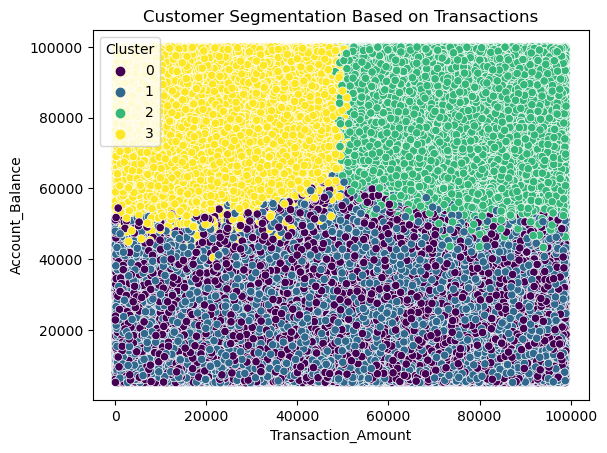

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="Transaction_Amount", y="Account_Balance", hue="Cluster", palette="viridis")
plt.title("Customer Segmentation Based on Transactions")
plt.show()


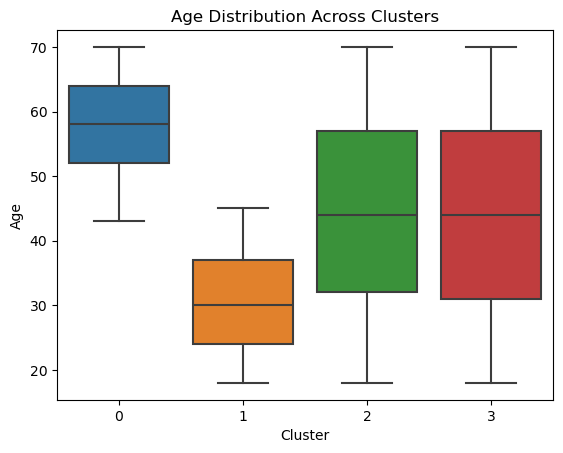

In [37]:
sns.boxplot(data=df, x="Cluster", y="Age")
plt.title("Age Distribution Across Clusters")
plt.show()


## Conclusion for clustering:  
**Methods Employed:**  
*Gausian Mixture Model: From the autoencoder results, we suspect that there are too many similarities between fraud and non-fraud transactions. This indicates that there will be a plenty of overlaping behaviors. In this case, GMM is very useful as it is a Probability-Based Segmentation method.*  

**Results:**
*GMM clusters the data into for clusters. They are listed below:*  
* Cluster 0: older customers,moderate transaction amounts, and low account balances
* Cluster 1：youngest group,similar transaction amounts, low account balances
* Cluster 2: middle-aged customers, high-value transactions, high account balances
* Cluster 3: middle-aged group, low transaction amounts,  high account balances  

*From the scatter plot, we observe that cluster 2 and 3 has wealthier customers indicated by high account balances and cluster 0 and 1 on the other hand. Boxplot helps us to ocnfirm that age variations in each group.*

**Business Campaigns:**  
* Cluster 0: Encourage financial security for retirees with retirement savings plans, fixed-income investments, tailored insurance options, and personalized financial advisory services to optimize their savings.
* Cluster 1: Attract young professionals and students with low-fee banking products, cashback rewards, and financial literacy programs like budgeting workshops to foster long-term loyalty.
* Cluster 2&3: To retain high-net-worth customers, businesses can offer exclusive wealth management, priority services, premium credit cards, and concierge support. Additionally, high-interest savings accounts and VIP loyalty programs can enhance engagement and loyalty.
* Cluster 3: Boost customer spending with special promotions, tiered interest rates, and exclusive partnerships with luxury brands and lifestyle services to enhance rewards and incentives.
